In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame
# import utils as ut

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load the san francisco data
months = ['05','06','07','08','09','10','11','12']
all_df = []
for m in months:
    all_df.append(pd.read_csv('../data/san_francisco/2018-'+m+'.csv'))
    
all_df = pd.concat(all_df)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Append the data
all_df = all_df.dropna()
# not_date = [d for d in all_df['created_at'] if type(d) ==float]
all_df['date'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in all_df['created_at']]

In [4]:
len(all_df)/10**2

18010.77

So if we divided up the tweets into chunks of 100, we should be able to create a model that is a little more robust, and specifically looks for words that account for AQI.

Before we do that, let's just see if we can apply TFIDF straight up to the word counts of the documents to predict AQI.

In [4]:
import random

def agg_tweets_by_date(docs, n_tweets=100):
    '''
    This function aggreggates tweets based on date, in clusters of the number of
    tweets specified in the arguments.
    
    docs: a dataframe with text and date
    n_tweets: the number of tweets to aggreggate
    '''
    random.seed(1)
    # Come up with a label for each tweet.
    agg_docs = []
    
    for d in set(docs['date']):
        date_docs = docs[docs['date'] == d]
        num_docs = int(len(date_docs)/n_tweets)*n_tweets
        
        # Discard any extras in this implementation...not ideal, 
        # but necessary for this quick prototype.
        text = date_docs['text'].to_numpy()[:num_docs].reshape(-1,100)
        summed_text = np.sum(text, axis=1)
        for t in summed_text:
            agg_docs.append([d, t])
    
    return pd.DataFrame(agg_docs, columns=['date','text'])
    
    
dd = agg_tweets_by_date(all_df)

In [5]:
# is it possible that these results can create a linear model with AQI?
aqi_2018 = pd.read_csv('../data/aqi_data/daily_aqi_by_county_2018.csv')
ca_aqi = aqi_2018[aqi_2018['State Name']=="California"]

# Add in the san francisco county
sf_aqi = ca_aqi[ca_aqi['county Name'] == 'San Francisco']


In [6]:
sf_aqi['date'] = pd.to_datetime(sf_aqi['Date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:

sf_aqi['date'] = [d.date() for d in sf_aqi['date']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
sf_mrg = pd.merge(left=dd, right=sf_aqi, left_on='date', right_on='date', how='left')

In [45]:
# Apply the tweet token vectorizer first to clean up the words
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import nltk

cleaned_tweets = []
lemmatizer = WordNetLemmatizer()
tt = TweetTokenizer()
stopword_list = nltk.corpus.stopwords.words("english")
health_tweets = sf_mrg['text']
for tweet in health_tweets:
    t = tweet.lower()
#     t = remove_special_characters(t)
    t = tt.tokenize(t)
    t = [w for w in t if w.isalpha()]
    t = [lemmatizer.lemmatize(w) for w in t]
#     t = [w for w in t if w not in words_to_remove]
    cleaned_tweets.append(t)
# This is so we can pass this value into the count vectorizer
rejoined_tweets = [" ".join(t) for t in cleaned_tweets]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(sf_mrg['text'], sf_mrg['AQI'], test_size=0.2)

In [47]:
# Create a tfidf representation of these tweets
tf_vect = TfidfVectorizer(max_df=0.01, min_df=5, stop_words="english")
X_enc = tf_vect.fit_transform(X_train)
X_test_enc = tf_vect.transform(X_test)

In [13]:
from sklearn.decomposition import TruncatedSVD

# Use many components...remember, we are scaling from a very
# large (10,000 features) to this smaller decomposition, so
# don't be afraid to scale it down!
svd = TruncatedSVD(n_components=100, n_iter=40, random_state=42)
x_svd = svd.fit_transform(X_enc)


In [16]:
x_svd_test = svd.transform(X_test_enc)

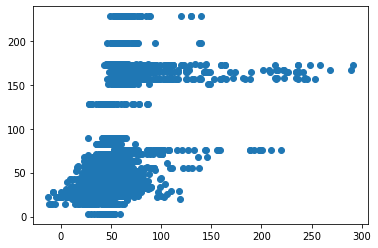

In [23]:
# Create a lasso model to predict the AQI
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

model = Lasso(alpha=0.00001)
model.fit(x_svd, y_train)

preds = model.predict(x_svd)

plt.scatter(preds, y_train)
plt.show()

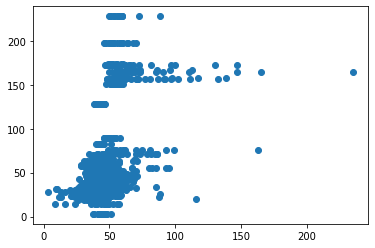

In [18]:
test_pred = model.predict(x_svd_test)
plt.scatter(test_pred, y_test)
plt.show()

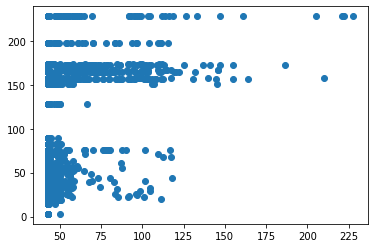

In [134]:
model = Lasso(alpha=0.001)
model.fit(X_enc, y_train)
preds = model.predict(X_enc)

plt.scatter(preds, y_train)
plt.show()

In [ ]:
model = Lasso(alpha=0.001)
model.fit(X_enc, y_train)
preds = model.predict(X_enc)

plt.scatter(preds, y_train)
plt.show()

In [ ]:
# Create a lasso model to predict the AQI
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.001)
model.fit(x_svd, y_train)

preds = model.predict(x_svd)

plt.scatter(preds, y_train)
plt.show()

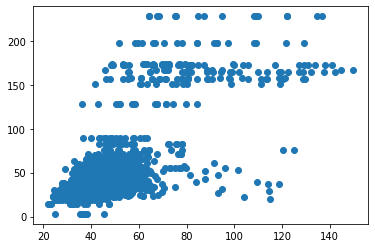

In [152]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(30)

model.fit(X_enc, y_train)

preds = model.predict(X_test_enc)
plt.scatter(preds, y_test)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_enc, y_train)

preds = model.predict(X_test_enc)
plt.scatter(preds, y_test)
plt.show()

It appears that in this method, our word vectors are just too big. We can likely reduce the max_df to 0.5, or even lower...look how often words like "cough" appear in a document broken up into 100 tweets.

Also, it looks like there might be a problem with how tfidf is creating the vectors. Seems like we need to do some preprocessing before trying this method out.

In [26]:
dd.shape

(17891, 2)

In [20]:
X_enc.shape

(742228, 922694)

## Applying a Log Transform to AQI
Professor Carlson recommends trying to fit the data to log-AQI, as we should equally weight a 20% different between an AQI of 50 and a 20% difference of a high AQI.

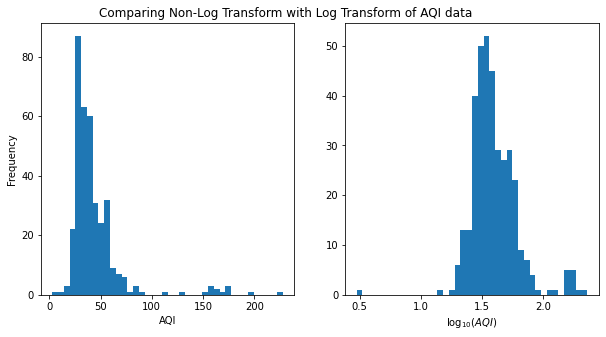

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(sf_aqi['AQI'], bins=40)
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.subplot(1,2,2)
plt.hist(np.log10(sf_aqi['AQI']), bins=40)
plt.xlabel("$\log_{10}(AQI)$")
plt.title("Comparing Non-Log Transform with Log Transform of AQI data", fontdict={'horizontalalignment':'right'})
plt.show()

As shown above, the density of AQI appears more Gaussian through the Log-Transform, which suggests that our data is indeed log-normal. 

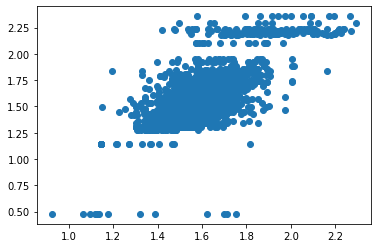

In [52]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(5)

model.fit(X_enc, np.log10(y_train))

preds = model.predict(X_test_enc)
plt.scatter(preds, np.log10(y_test))
plt.show()

The log transform appears to work OK in this case, with a clear linear relationship between predicted and actual log(AQI).